# Оценка потенциального экономического эффекта от внедрения полученного решения



Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

In [33]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing, manifold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import ttest_rel
import statsmodels
import statsmodels.api as sm
from sklearn import ensemble, linear_model,model_selection, metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [34]:
def get_data():
    X = pd.read_csv('orange_small_churn_data.txt')
    Y = pd.read_csv('orange_small_churn_labels.txt',header=None)
    Y.rename(columns={0: 'label'},inplace=True)
    churn_test = pd.read_csv('orange_small_churn_test_data.csv').drop(['ID'],axis = 1)
    return (X,Y,churn_test)

In [35]:
def labelEncoder(data):
    data.apply(str)
    le = preprocessing.LabelEncoder()
    for m in range(data.shape[1]):
        le.fit(data.iloc[:,m])
        data.iloc[:,m] = le.transform(data.iloc[:,m])        
    return data

In [36]:
def prepare_data(data):
    num = data.iloc[:, 1:191]
    cat = data.iloc[:, 191:]
    num.dropna(axis=1, thresh=num.shape[0]*0.05, subset=None, inplace=True)
    cat.dropna(axis=1, thresh=num.shape[0]*0.05, subset=None, inplace=True)
    num.fillna(num.mean(),inplace=True)
    cat.fillna('NO', inplace=True)
    data_new = pd.concat([num,labelEncoder(cat)],axis=1)
    return data_new

In [37]:
def prepare_data_zero(data):
    num = data.iloc[:, 1:191]
    cat = data.iloc[:, 191:]
    num.dropna(axis=1, thresh=num.shape[0]*0.05, subset=None, inplace=True)
    cat.dropna(axis=1, thresh=num.shape[0]*0.05, subset=None, inplace=True)
    num.fillna(0,inplace=True)
    cat.fillna('NO', inplace=True)
    data_new = pd.concat([num,labelEncoder(cat)],axis=1)
    return data_new

In [38]:
def prepare_data_cat_top(data):
    num = data.iloc[:, 1:191]
    cat = data.iloc[:, 191:]
    num.dropna(axis=1, thresh=num.shape[0]*0.05, subset=None, inplace=True)
    cat.dropna(axis=1, thresh=num.shape[0]*0.05, subset=None, inplace=True)
    num.fillna(num.mean(),inplace=True)
    for i in range(len(cat.columns.values)):
        cat.fillna(cat.iloc[:,i].value_counts().index[0], inplace=True)
    data_new = pd.concat([num,labelEncoder(cat)],axis=1)
    return data_new

In [39]:
def result(estimator, X, Y):
    score = ['roc_auc', 'precision', 'recall', 'f1_weighted']
    skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    for i in score:
        res = model_selection.cross_val_score(estimator, X, Y, scoring=i, cv = skf)
        print("Scores for metric %s:" % i)
        print(res)
        print(res.mean())
    print('==============================================')

In [40]:
def undersampling_X (X, y, ratio):
    data = pd.concat([X,y],axis=1)
    Churn = data[data['label'] == 1]
    NoChurn = data[data['label'] == -1]
    size_churn = len(Churn)
    size_nochurn = len(NoChurn)
    size_for_new_data = np.random.randint(0, size_nochurn , size_churn * ratio)
    new_date = pd.concat([Churn, NoChurn.iloc[size_for_new_data,:]])
    return new_date.iloc[:,:77]

In [41]:
def undersampling_y (X, y, ratio):
    data = pd.concat([X,y],axis=1)
    Churn = data[data['label'] == 1]
    NoChurn = data[data['label'] == -1]
    size_churn = len(Churn)
    size_nochurn = len(NoChurn)
    size_for_new_data = np.random.randint(0, size_nochurn , size_churn * ratio)
    new_date = pd.concat([Churn, NoChurn.iloc[size_for_new_data,:]])
    return new_date.iloc[:,77:]

In [42]:
def data_for_baseline (X,Y):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=123)
    return X_train, X_test, y_train, y_test 

In [43]:
def algo_predict (values, threshold):
    predict = []
    for i in values:
        if i >= threshold:
            predict.append(1)
        else:
            predict.append(-1)
    return np.array(predict)

In [44]:
X,y,_ = get_data()

In [45]:
X = prepare_data(X)

**Обучим модель по параметрам, полученным на прошлом поинте**

In [46]:
l1 = Lasso(alpha = 0.01).fit(X, y)
model = SelectFromModel(l1, prefit=True)
X_new = model.transform(X)
X_train, X_test, y_train, y_test = data_for_baseline(X_new,y)
estimator=xgb.XGBClassifier( n_estimators=65, max_depth = 4,  sample_weight = 11)
estimator.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=65, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, sample_weight=11, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

Постройте простую экономическую модель для оценки эффекта от внедрения полученного решения на практике.

Например, введите следующие параметры:

* сколько денег в среднем приносит один пользователь в месяц;

* сколько денег в среднем вы будете вкладывать в удержание одного пользователя;

* с какой вероятностью пользователь примет ваше предложение;

* сколько пользователей (например, топ 1% или топ 25% согласно ранжированию по вашей модели) будет участвовать в кампании.

1. Введите еще несколько параметров и на их основе постройте простую экономическую модель: формулу по которой в зависимости от значения исходных параметров вы сможете рассчитать экономический эффект от проведения кампании (= сколько денег вы получили (или наоборот потеряли) от проведения кампании по удержанию) с использование вашей модели.

In [47]:
def model_without (revenue, top ):
    values = estimator.predict_proba(X_test)[:,1]
    lst = [(value, int(y_test.values[i]), i) for (i,value) in enumerate(values)]
    lst.sort(key = lambda x: -x[0])
    equety = []
    for i in top:
        cnt = int(len(lst) * i /100)
        cnt_churn = len([value for (i,value) in enumerate(lst[:cnt]) if value[1] == 1])
        income = cnt * revenue - cnt_churn * revenue
        equety.append(income)
    return equety

In [48]:
def model_with (revenue, cost, proba, top):
    values = estimator.predict_proba(X_test)[:,1]
    lst = [(value, int(y_test.values[i]), i) for (i,value) in enumerate(values)]
    lst.sort(key = lambda x: -x[0])
    equety = []
    for i in top:
        cnt = int(len(lst) * i /100)
        cnt_churn = len([value for (i,value) in enumerate(lst[:cnt]) if value[1] == 1])
        costs = cost * cnt
        income = cnt * revenue - ((1 - proba) * cnt_churn * revenue)
        equety.append(income - costs)
    return equety
        

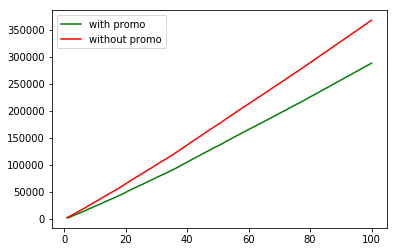

In [49]:
with_promo = model_with (revenue = 100, cost = 20, proba = 0.01, top = range(1,101))
without_promo = model_without (revenue = 100, top = range(1,101))
x = range(1, 101, 1)
plot(x, with_promo, color="g", label="with promo")
plot(x, without_promo, color="r", label="without promo")
plt.legend()
plt.show()


в зависимости от цены удержания и вероятности, модель становится лучше/хуже

немного изменю модель, уберу влияние оставшихся абонентов 

In [50]:
def model_updated (revenue, cost, proba, top):
    values = estimator.predict_proba(X_test)[:,1]
    lst = [(value, int(y_test.values[i]), i) for (i,value) in enumerate(values)]
    lst.sort(key = lambda x: -x[0])
    equety = []
    income = 0
    for i in top:
        cnt = int(len(lst) * i /100)
        cnt_churn = len([value for (i,value) in enumerate(lst[:cnt]) if value[1] == 1])
        costs = cost * cnt
        income += revenue*proba*cnt_churn
        equety.append(income - costs)
        income = 0
    return equety

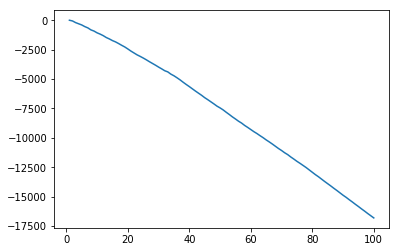

In [51]:
plot(x, model_updated(revenue = 100, cost = 5, proba = 0.1, top = range(1,101)))

2. Исходя из введенных параметров проанализируйте, какой топ пользователей, склонных к оттоку согласно модели, оптимально выбрать для проведения кампании по удержанию для таким образом, чтобы экономический эффект был наибольшим?

В зависимости от cost и proba. топ всегда будет разный. зафиксируем cost - 5 % от ревеню / вер-ть принятия предложения  30 %
иначе совсем не интересно) - все в минус

In [52]:
res = model_updated(revenue = 100, cost = 5, proba = 0.3, top = range(1,101))

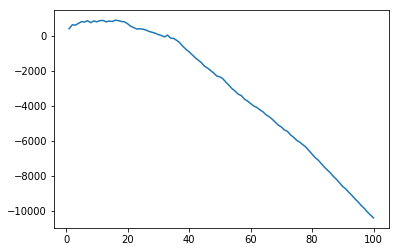

In [53]:
plot(x, res)

In [54]:
print('max revenue is %s with top of %d percents' % (max(res), res.index(max(res))))

max revenue is 880.0 with top of 15 percents


3. Попробуйте усложнить экономическую модель. Добавьте еще несколько параметров и поиграйте с ними (например, измените стоимость удержания и вероятность, с которой пользователь принимает предложение), проанализируйте как меняется оптимальный размер топа?

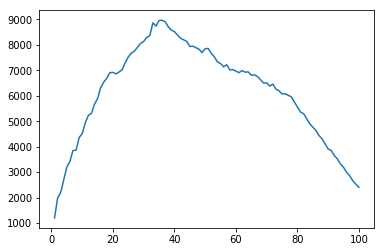

In [55]:
plot(x, model_updated(revenue = 100, cost = 5, proba = 0.7, top = range(1,101)))

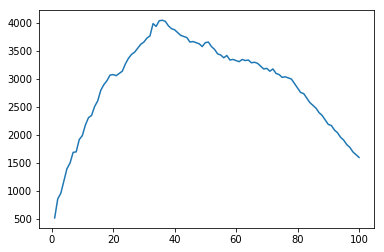

In [56]:
plot(x, model_updated(revenue = 100, cost = 2, proba = 0.3, top = range(1,101)))

как и говорил ранее, увеличение вероятности принятия предложения либо уменьшении стоиомсти привелчения веде к увеличению доходов от кампании

**пусть клиент принявший предложение и оставшийся с компанией получает скидку 20/30/50 % на обслуживаение(привет мтс) посмотрим на модель**

In [57]:
def model_sale (revenue, cost, proba, top):
    values = estimator.predict_proba(X_test)[:,1]
    lst = [(value, int(y_test.values[i]), i) for (i,value) in enumerate(values)]
    lst.sort(key = lambda x: -x[0])
    equety = []
    
    sale = [20, 30, 50]
    for j in sale:
        income = 0
        for i in top:
            cnt = int(len(lst) * i /100)
            cnt_churn = len([value for (i,value) in enumerate(lst[:cnt]) if value[1] == 1])
            costs = cost * cnt
            income += (revenue - revenue * j/100) * proba * cnt_churn
            equety.append(income - costs)
            income = 0
    program_20 = equety[:len(top)]
    program_30 = equety[len(top):2*len(top)]
    program_50 = equety[2*len(top):]
    return  program_20,  program_30,  program_50

In [58]:
program_20,  program_30,  program_50 = model_sale(revenue = 100, cost = 5, proba = 0.7, top = range(1,101))

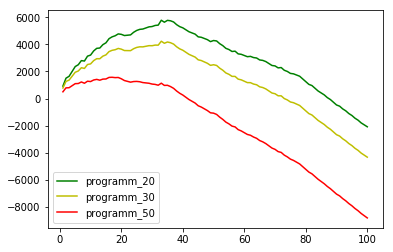

In [59]:
plot(x, program_20, color="g", label="programm_20" )
plot(x, program_30, color="y", label="programm_30" )
plot(x, program_50, color="r", label="programm_50" )
plt.legend()

как видим, даже при вероятности принятия предлоежения в 0.7 скидка в 50% делает модель околонулевой

4. Всегда ли применение модели экономически оправданно? Приведите пример набора значений параметров, при которых применение модели перестает быть оправданным.

конечнно не всегда. при костах в 20% . модель летит в трубу

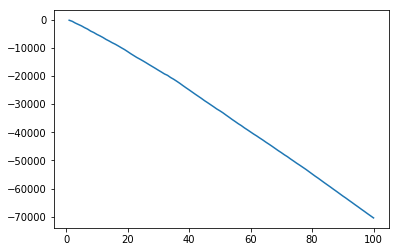

In [60]:
plot(x, model_updated(revenue = 100, cost = 20, proba = 0.3, top = range(1,101)))

5. Оцените изменение экономического эффекта от проведения кампании по удержанию при увеличении качества модели на 1%? На 3%? При ответе на вопрос укажите, по какой метрике вы оцениваете качество.

In [61]:
from sklearn.metrics import roc_auc_score, recall_score

In [62]:
roc_auc_score(estimator.predict(X_test),y_test)

0.860450563204005

в задачах на отток более важным явдяется ошибка второго рода. ее и нужно уменьшать. или иными словами повышть recall.
recall  - это доля угаданных положительных классов ,среди всех положильтеных классов. Увелить его можно только уменьши false negative ответа - иными словами, нам нужно понизить threshold, увеличив мозность модели, но тогда упадет precision.
Вопрос баланса/ без четкого понимая сколько стоит каждый абонент задачу не решить


возьмем базовую модель  cost - 5 % от ревеню / вер-ть принятия предложения  30 %

max revenue is 880.0 with top of 15 percents


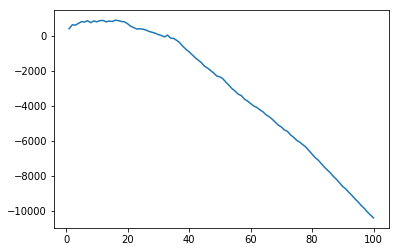

In [131]:
res = model_updated(revenue = 100, cost = 5, proba = 0.3, top = range(1,101))

plot(x, res)

print('max revenue is %s with top of %d percents' % (max(res), res.index(max(res))))

rec = tp/(tr + fn)

In [67]:
y_pred = estimator.predict(X_test)

In [119]:
rec = recall_score(y_test.values.flatten(), y_pred)

In [120]:
rec

0.0125

In [121]:
tp = ((y_pred == 1) & (y_test.values.flatten() == y_pred)).sum()

In [122]:
fn = ((y_pred == -1) & (y_test.values.flatten() == 1)).sum()

In [130]:
fn

316

In [128]:
recall = tp/(tp+fn)

In [129]:
tp / (recall  * 1.01) - tp

312.83168316831683

In [136]:
tp / (recall  * 1.03) - tp

306.6796116504854

таким образов - увеличение кач-ва модели на 1 и 3  процент ведет к уменьшению fn на 4 и 10 соответсвнно, сл-но на 4 и 10 увеличится верное предсказываение
(при базовой модели 4/10* 100* 0,3 = +120/300 рублей прирост) 

6. Как вы думаете, является ли экономически оправданным вложение средств в улучшение качества модели? На сколько нужно улучшить модель, чтобы это качественно сказалось на экономическом эффекте от удержания?

все зависит от цены и объема работ. Если классифактор сможет определять ,например, 95% оттока. при этому удержаание абонентов будет стоить мало. то , да, улчщение кач-ва классфикатора приведет к улучшению фин модели